In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_excel('C:/Users/ncole/Downloads/Solar Sizing Data Complete.xlsx',index_col = 0,sheet_name = 'Sheet1',squeeze = True)
df2 = pd.read_excel('C:/Users/ncole/Documents/Python Things/REDB Copy.xlsx', sheet_name = 'Master', usecols = ['Address', 'Latitude', 'Longitude', 'Zip', 'ApplYear', 'ElecSoldTo'] )
df2.set_index('Address', inplace = True)
df.set_index('Address', inplace = True)
df2 = df2.loc[~df2.index.duplicated()]
df = df.loc[~df.index.duplicated()]

df_complete = pd.concat([df,df2], axis = 1, join = 'inner')
#df_complete['Full Address'] = df2['Full Address']

(10099, 22)
(8497, 22)


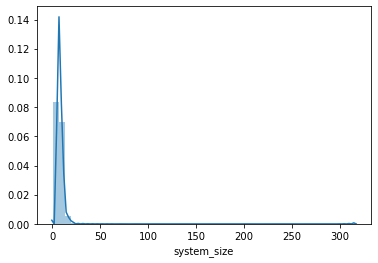

In [3]:

print(df_complete.shape)
#Filter outliers to prevent model overfitting
df_complete = df_complete[(df_complete['system_size'] < 15) & (df_complete['sqft'] >= 500)]
address = df_complete.index
print(df_complete.shape)
sns.distplot(df['system_size'])
y = df_complete['system_size'].values


<AxesSubplot:>

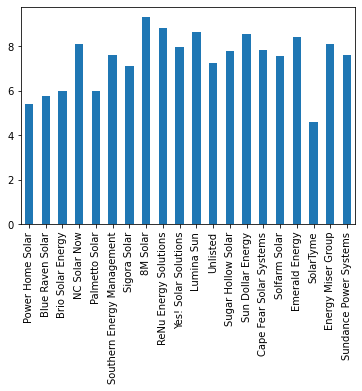

In [4]:
#Perform analysis of Installer Company's and impact on system_size
largest = df_complete['InstallerCompany'].value_counts().nlargest(20).index
df_prac = df_complete.set_index('InstallerCompany')
df_prac.groupby('InstallerCompany')['system_size'].median().loc[largest].plot.bar()
#It seems that there is signficant variance by installer and worth creating dummy variables for


In [5]:
#Create Dummy Variables for Installer and evaluate correlation with system size
installer = pd.get_dummies(df_complete['InstallerCompany'])
installer_largest = installer[largest]
installer_largest.head()

,Power Home Solar,Blue Raven Solar,Brio Solar Energy,NC Solar Now,Palmetto Solar,Southern Energy Management,Sigora Solar,8M Solar,ReNu Energy Solutions,Yes! Solar Solutions,Lumina Sun,Unlisted,Sugar Hollow Solar,Sun Dollar Energy,Cape Fear Solar Systems,Solfarm Solar,Emerald Energy,SolarTyme,Energy Miser Group,Sundance Power Systems
Address,,,,,,,,,,,,,,,,,,,,
6909 Sardis Green Court,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368 Trammel Gap Road,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1470 Midlake Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1985 Brevard Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1000 Exeter Field Circle,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Index(['sqft', 'yr_built', 'stories', 'improvementYear', 'system_size',
       'rooms', 'beds', 'baths', 'ApplYear', 'Latitude', 'Longitude'],
      dtype='object')


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

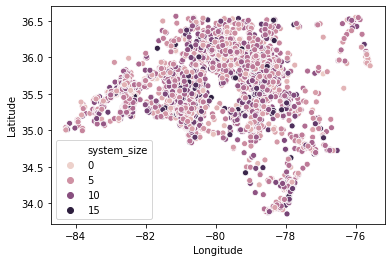

In [6]:
print(df_complete.corr()['system_size'].index)
#df_complete.groupby('Zip')['system_size'].median().plot.bar()
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'system_size', data = df_complete)

In [7]:
df_complete.drop(['improvementYear'],axis = 1, inplace=True)

#Remove outliers to get more accurate predictions


In [8]:
df_complete.corr()['system_size'].sort_values(ascending = False)

system_size    1.000000
sqft           0.330184
baths          0.236341
rooms          0.207359
beds           0.175092
yr_built       0.044137
stories        0.036997
Longitude      0.025558
Latitude      -0.003334
ApplYear      -0.005297
Name: system_size, dtype: float64

In [9]:
#elec_sold_to = pd.get_dummies(df_complete['ElecSoldTo'])
#elec_sold_to = elec_sold_to[elec_sellers]
#elec_sold_to.corr(df_complete['system_size'])

In [10]:
#Want to do min-max-scaling prior to including categorical variables
numeric = df_complete.select_dtypes(include=np.number)
#numeric.drop('ApplYear',inplace = True, axis = 1)

for column in numeric.columns:
    if (numeric[column].isnull().sum()/len(numeric[column]) > .5):
           numeric.drop([column],axis = 1, inplace = True)
        
#numeric.info()

columns = numeric.columns.tolist()

#Fill nulls with median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df_numeric = imputer.fit_transform(numeric)
df_numeric = pd.DataFrame(data = df_numeric, columns = columns)


#Add Dummy variable for heating system type
heating = pd.get_dummies(df_complete['heating'])
heating.rename(columns={'Yes': 'Has Heater', 'Unknown':'Heating Unclear', 'Central': 'Central Heating'},inplace = True)
heating['Address'] = address
heating.set_index('Address',inplace = True)
df_numeric['Address'] = address
df_numeric.set_index('Address',inplace = True)
df_ready = pd.concat([heating, df_numeric], axis = 1, join = 'inner')
df_ready = pd.concat([installer_largest, df_ready],axis = 1, join = 'inner')
#Add Dummy Variable for 

#Apply Dummy Variable column to the presence of a poll
df_ready.drop(['Latitude', 'Longitude'],inplace = True, axis = 1)
df_ready['pool'] = df_complete['pool'].apply(lambda x: 0.0 if pd.isna else 1.0)
df_ready.corr()['system_size'].sort_values(ascending = False)
df_ready.drop('system_size',inplace = True, axis = 1)
X = df_ready


#Split data prior to numeric fitting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#df_complete.drop('system_size',inplace = True, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#Scale numeric non-null feature columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#df_numeric_final = pd.DataFrame(df_numeric_final, columns = columns)
#df_numeric_final['ApplYear'] = df_complete['ApplYear']
#df_numeric_final['Address'] = address
#df_numeric_final.info()

C:\Users\ncole\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
#df_ready.corr()['system_size'].sort_values(ascending = False)
#df_complete.corr()['system_size']
#df_ready['pool'].value_counts()

In [12]:
#df_complete.groupby('InstallerCompany')['system_size'].median().plot().bar()
#df_complete['cooling'].value_counts()
#df_complete['heating'].isnull().sum()



#cat_columns = np.setdiff1d(df_complete.columns, numeric.columns)
#for columns in cat_columns:
 #   print(columns)

In [13]:
df_complete.drop('style',inplace = True, axis = 1)

#df_complete.groupby('style')['system_size'].median().plot().bar()

#Want to create dummy variable dataframe for top 10 installers and then concatenate


df_complete = pd.concat([df_complete,pool_dummy],axis = 1)
#df = pd.concat([df,styles_dummy],axis=1)
df_complete = pd.concat([df_complete,cooling],axis=1)
df_complete = pd.concat([df_complete,heating],axis=1)

df_complete = pd.concat([df_complete,comp_dummy],axis=1)
df_complete = pd.concat([df_complete, elec_sold_to],axis = 1)

df_complete.corr()['system_size'].sort_values(ascending = False)[0:15]

In [14]:
#Cannot figure out how to keep the dataframe rows the same, while merging columns.
#Create dummy dataframe for heating type


In [15]:
#df_ready['pool'].describe()
#sns.heatmap(df_ready.corr(),annot=True)


In [16]:
#Want to drop columns with too many null values to reliably imput


In [17]:
#Replace Null values with median of column value

#X_train[:, 0:8] = imputer.transform(X_train[:, 0:3])

In [18]:
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

from sklearn import metrics 
print(metrics.mean_absolute_error(y_test, predictions)) 
print(metrics.mean_squared_error(y_test, predictions)) 
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
#X.columns

1.8141169430584347
5.190346797568419
2.2782332623259673


coeff_df = pd.DataFrame(data = lm.coef_, columns = df_ready.columns)
coeff_df

predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)

sns.distplot((y_test-predictions),bins=50);

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

df['system_size'].median()

#Testing LinearSVR turns out to be suboptimal solution
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

param_grid = {'C':[.1, .5, 1, 10, 100], 'max_iter':[10,100,1000,1500], 'loss':['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(LinearSVR(),param_grid, verbose = 3)

#grid.best_estimator
grid.fit(X_train, y_train)

results = grid.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, results))
print('MSE:', metrics.mean_squared_error(y_test, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, results)))


grid.best_estimator_

#Test DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor
param_grid = {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'], 'max_features': [2,4,6,8,10,12], 'min_samples_leaf':[2,10,50,100], 'max_depth': [None,3,5,10]}
grid = GridSearchCV(DecisionTreeRegressor(),param_grid,verbose=3)
grid.fit(X_train,y_train)


results = grid.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, results))
print('MSE:', metrics.mean_squared_error(y_test, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, results)))
grid.best_estimator_

from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt


param_grid = {'alpha': [0,.1,.3,.5,.75,1], 'max_iter': [100,500,1000,1500], 'normalize': [True,False]}
grid = GridSearchCV(Lasso(),param_grid)
grid.fit(X_train,y_train)


#plt.plot(range(len(X.columns)), coeffs)


params = grid.best_params_
coeffs = grid.best_estimator_.coef_
results = pd.DataFrame([list(coeffs)],columns= X.columns)
results.head()

int_cols = df_complete.dtypes[df_complete.dtypes.values == 'float64'].index.tolist()





X_train[best_cols] = X_train[best_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_test[best_cols] = X_test[best_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


datas = pd.DataFrame(X_train)
datas.columns

In [19]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode= 'min',verbose = 1, patience = 25)
model = Sequential()
model.add(Dense(len(df_ready.columns),activation = 'relu'))
model.add(Dense(len(df_ready.columns),activation = 'relu'))
model.add(Dense(len(df_ready.columns),activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x=X_train, y=y_train, validation_data = (X_test, y_test), callbacks = [early_stop], batch_size = 128, epochs = 200)

Epoch 1/200
47/47 [==============================] - 1s 13ms/step - loss: 48.7961 - val_loss: 7.9185
Epoch 2/200
47/47 [==============================] - 0s 2ms/step - loss: 7.7618 - val_loss: 6.1211
Epoch 3/200
47/47 [==============================] - 0s 2ms/step - loss: 6.1143 - val_loss: 5.6187
Epoch 4/200
47/47 [==============================] - 0s 2ms/step - loss: 5.6484 - val_loss: 5.5035
Epoch 5/200
47/47 [==============================] - 0s 2ms/step - loss: 5.5959 - val_loss: 5.4272
Epoch 6/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4815 - val_loss: 5.3956
Epoch 7/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4910 - val_loss: 5.3477
Epoch 8/200
47/47 [==============================] - 0s 2ms/step - loss: 5.5943 - val_loss: 5.3182
Epoch 9/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3598 - val_loss: 5.2907
Epoch 10/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4870 - val_loss: 5.2635
Epoch 1

80/80 [==============================] - 0s 454us/step - loss: 5.2288


5.228796005249023

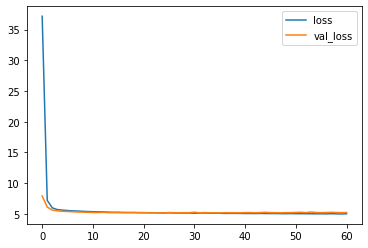

In [20]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot()

model.evaluate(X_test, y_test)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [22]:
predictions = model.predict(X_test)
np.sqrt(mean_squared_error(y_test,predictions))/(np.median(y_test))

0.32996481310999676

In [23]:
mean_absolute_error(y_test,predictions)

1.8050751336871875

In [24]:
explained_variance_score(y_test, predictions)

0.23745323098617055

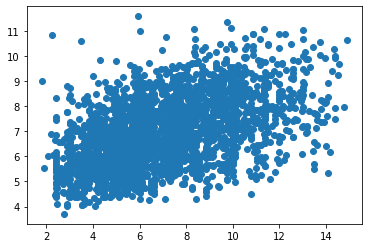

In [25]:
plt.scatter(y_test,predictions)

Epoch 1/200
47/47 [==============================] - 0s 3ms/step - loss: 56.7378 - val_loss: 52.1397
Epoch 2/200
47/47 [==============================] - 0s 2ms/step - loss: 50.3182 - val_loss: 43.3951
Epoch 3/200
47/47 [==============================] - 0s 1ms/step - loss: 40.7432 - val_loss: 30.0185
Epoch 4/200
47/47 [==============================] - 0s 1ms/step - loss: 26.4552 - val_loss: 15.4244
Epoch 5/200
47/47 [==============================] - 0s 2ms/step - loss: 12.9651 - val_loss: 7.9893
Epoch 6/200
47/47 [==============================] - 0s 1ms/step - loss: 7.7247 - val_loss: 6.9747
Epoch 7/200
47/47 [==============================] - 0s 1ms/step - loss: 7.0842 - val_loss: 6.7412
Epoch 8/200
47/47 [==============================] - 0s 1ms/step - loss: 6.8590 - val_loss: 6.5449
Epoch 9/200
47/47 [==============================] - 0s 1ms/step - loss: 6.6142 - val_loss: 6.3783
Epoch 10/200
47/47 [==============================] - 0s 2ms/step - loss: 6.4718 - val_loss: 6.2374


Epoch 83/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3378 - val_loss: 5.2102
Epoch 84/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2310 - val_loss: 5.2026
Epoch 85/200
47/47 [==============================] - 0s 2ms/step - loss: 5.1348 - val_loss: 5.2050
Epoch 86/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2246 - val_loss: 5.2024
Epoch 87/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2176 - val_loss: 5.2039
Epoch 88/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2496 - val_loss: 5.2045
Epoch 89/200
47/47 [==============================] - 0s 2ms/step - loss: 5.1577 - val_loss: 5.1990
Epoch 90/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4788 - val_loss: 5.1961
Epoch 91/200
47/47 [==============================] - 0s 3ms/step - loss: 5.2079 - val_loss: 5.2097
Epoch 92/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3471 - val_loss: 5.1942


47/47 [==============================] - 0s 3ms/step - loss: 5.0888 - val_loss: 5.1774
Epoch 165/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3278 - val_loss: 5.1860
Epoch 166/200
47/47 [==============================] - 0s 1ms/step - loss: 5.1637 - val_loss: 5.1803
Epoch 167/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3983 - val_loss: 5.1774
Epoch 168/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2673 - val_loss: 5.1769
Epoch 169/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2394 - val_loss: 5.1778
Epoch 170/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2378 - val_loss: 5.1806
Epoch 171/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2575 - val_loss: 5.1820
Epoch 172/200
47/47 [==============================] - 0s 1ms/step - loss: 5.1878 - val_loss: 5.1770
Epoch 173/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2367 - val_loss: 5.1812
Epoc

5.178377151489258

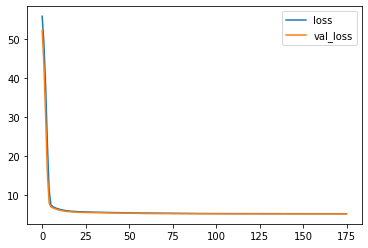

In [26]:
model2 = Sequential()
model2.add(Dense(5,activation = 'relu'))
model2.add(Dense(5,activation = 'relu'))
model2.add(Dense(5,activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
model2.add(Dense(1))

model2.compile(optimizer = 'adam', loss = 'mse')
model2.fit(x=X_train, y=y_train, callbacks = [early_stop], validation_data = (X_test, y_test), batch_size = 128, epochs = 200)

df_loss2 = pd.DataFrame(model2.history.history)
df_loss2.plot()

model2.evaluate(X_test, y_test)

Epoch 1/200
47/47 [==============================] - 0s 3ms/step - loss: 58.0923 - val_loss: 55.5674
Epoch 2/200
47/47 [==============================] - 0s 1ms/step - loss: 54.5452 - val_loss: 50.1190
Epoch 3/200
47/47 [==============================] - 0s 2ms/step - loss: 47.8136 - val_loss: 36.4567
Epoch 4/200
47/47 [==============================] - 0s 2ms/step - loss: 31.4522 - val_loss: 16.3253
Epoch 5/200
47/47 [==============================] - 0s 1ms/step - loss: 13.1915 - val_loss: 7.4916
Epoch 6/200
47/47 [==============================] - 0s 1ms/step - loss: 7.4366 - val_loss: 7.0540
Epoch 7/200
47/47 [==============================] - 0s 3ms/step - loss: 7.2991 - val_loss: 6.7992
Epoch 8/200
47/47 [==============================] - 0s 2ms/step - loss: 6.9325 - val_loss: 6.5991
Epoch 9/200
47/47 [==============================] - 0s 1ms/step - loss: 6.7446 - val_loss: 6.4188
Epoch 10/200
47/47 [==============================] - 0s 1ms/step - loss: 6.6159 - val_loss: 6.2705


Epoch 83/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4077 - val_loss: 5.2453
Epoch 84/200
47/47 [==============================] - 0s 3ms/step - loss: 5.2617 - val_loss: 5.2153
Epoch 85/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4066 - val_loss: 5.2116
Epoch 86/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2514 - val_loss: 5.2074
Epoch 87/200
47/47 [==============================] - 0s 1ms/step - loss: 5.1166 - val_loss: 5.2180
Epoch 88/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2498 - val_loss: 5.2045
Epoch 89/200
47/47 [==============================] - 0s 1ms/step - loss: 5.1605 - val_loss: 5.2003
Epoch 90/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3365 - val_loss: 5.2011
Epoch 91/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2579 - val_loss: 5.1989
Epoch 92/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3086 - val_loss: 5.2032


5.1882004737854

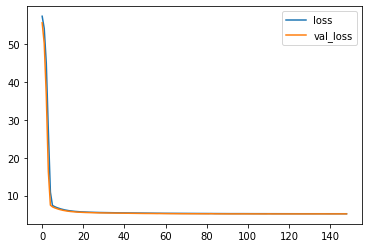

In [27]:
model3 = Sequential()
model3.add(Dense(5,activation = 'relu'))
model3.add(Dense(5,activation = 'relu'))
model3.add(Dense(5,activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
model3.add(Dense(1))

model3.compile(optimizer = 'adam', loss = 'mse')
model3.fit(x=X_train, y=y_train, callbacks = [early_stop], validation_data = (X_test, y_test), batch_size = 128, epochs = 200)

df_loss3 = pd.DataFrame(model3.history.history)
df_loss3.plot()

model3.evaluate(X_test, y_test)

Epoch 1/200
47/47 [==============================] - 0s 3ms/step - loss: 55.5633 - val_loss: 50.8251
Epoch 2/200
47/47 [==============================] - 0s 1ms/step - loss: 49.2267 - val_loss: 44.5098
Epoch 3/200
47/47 [==============================] - 0s 1ms/step - loss: 43.4249 - val_loss: 38.1092
Epoch 4/200
47/47 [==============================] - 0s 1ms/step - loss: 37.7963 - val_loss: 31.6993
Epoch 5/200
47/47 [==============================] - 0s 1ms/step - loss: 30.5618 - val_loss: 25.6378
Epoch 6/200
47/47 [==============================] - 0s 2ms/step - loss: 25.3391 - val_loss: 20.2456
Epoch 7/200
47/47 [==============================] - 0s 3ms/step - loss: 19.7585 - val_loss: 15.7922
Epoch 8/200
47/47 [==============================] - 0s 1ms/step - loss: 15.1904 - val_loss: 12.1560
Epoch 9/200
47/47 [==============================] - 0s 1ms/step - loss: 11.7737 - val_loss: 8.9777
Epoch 10/200
47/47 [==============================] - 0s 1ms/step - loss: 8.5327 - val_loss:

Epoch 83/200
47/47 [==============================] - 0s 3ms/step - loss: 5.2373 - val_loss: 5.2701
Epoch 84/200
47/47 [==============================] - 0s 1ms/step - loss: 5.4178 - val_loss: 5.2672
Epoch 85/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2644 - val_loss: 5.2645
Epoch 86/200
47/47 [==============================] - 0s 1ms/step - loss: 5.4045 - val_loss: 5.2611
Epoch 87/200
47/47 [==============================] - 0s 2ms/step - loss: 5.4554 - val_loss: 5.2587
Epoch 88/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3874 - val_loss: 5.2562
Epoch 89/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3246 - val_loss: 5.2532
Epoch 90/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3793 - val_loss: 5.2513
Epoch 91/200
47/47 [==============================] - 0s 1ms/step - loss: 5.4945 - val_loss: 5.2506
Epoch 92/200
47/47 [==============================] - 0s 1ms/step - loss: 5.4388 - val_loss: 5.2475


47/47 [==============================] - 0s 1ms/step - loss: 5.2811 - val_loss: 5.1875
Epoch 165/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2991 - val_loss: 5.1853
Epoch 166/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2977 - val_loss: 5.1857
Epoch 167/200
47/47 [==============================] - 0s 1ms/step - loss: 5.3009 - val_loss: 5.1868
Epoch 168/200
47/47 [==============================] - 0s 1ms/step - loss: 5.1525 - val_loss: 5.1851
Epoch 169/200
47/47 [==============================] - 0s 1ms/step - loss: 5.2012 - val_loss: 5.1891
Epoch 170/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3119 - val_loss: 5.1879
Epoch 171/200
47/47 [==============================] - 0s 2ms/step - loss: 5.2393 - val_loss: 5.1843
Epoch 172/200
47/47 [==============================] - 0s 2ms/step - loss: 5.3586 - val_loss: 5.1847
Epoch 173/200
47/47 [==============================] - 0s 2ms/step - loss: 5.1613 - val_loss: 5.1835
Epoc

5.1809611320495605

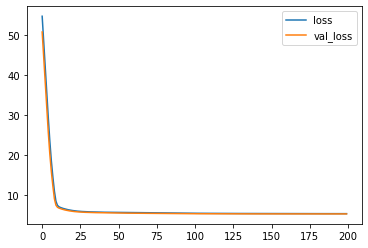

In [28]:
model4 = Sequential()
model4.add(Dense(5,activation = 'relu'))
model4.add(Dense(1))

model4.compile(optimizer = 'adam', loss = 'mse')
model4.fit(x=X_train, y=y_train, callbacks = [early_stop], validation_data = (X_test, y_test), batch_size = 128, epochs = 200)

df_loss4 = pd.DataFrame(model4.history.history)
df_loss4.plot()

model4.evaluate(X_test, y_test)

Epoch 1/200
47/47 [==============================] - 1s 12ms/step - loss: 22.4004 - val_loss: 5.9506
Epoch 2/200
47/47 [==============================] - 0s 11ms/step - loss: 5.8140 - val_loss: 5.4078
Epoch 3/200
47/47 [==============================] - 0s 10ms/step - loss: 5.3734 - val_loss: 5.3034
Epoch 4/200
47/47 [==============================] - 0s 10ms/step - loss: 5.3299 - val_loss: 5.4176
Epoch 5/200
47/47 [==============================] - 0s 10ms/step - loss: 5.2701 - val_loss: 5.5543
Epoch 6/200
47/47 [==============================] - 0s 10ms/step - loss: 5.3412 - val_loss: 5.2564
Epoch 7/200
47/47 [==============================] - 0s 10ms/step - loss: 5.0952 - val_loss: 5.2292
Epoch 8/200
47/47 [==============================] - 0s 10ms/step - loss: 5.2917 - val_loss: 5.2310
Epoch 9/200
47/47 [==============================] - 0s 10ms/step - loss: 5.2163 - val_loss: 5.3564
Epoch 10/200
47/47 [==============================] - 0s 10ms/step - loss: 5.0662 - val_loss: 5.205

5.2964887619018555

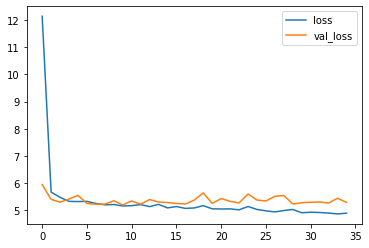

In [29]:
model5 = Sequential()
model5.add(Dense(512,activation = 'relu'))
model5.add(Dense(512,activation = 'relu'))
model5.add(Dense(512,activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
model5.add(Dense(1, activation = 'relu'))

model5.compile(optimizer = 'adam', loss = 'mse')
model5.fit(x=X_train, y=y_train, callbacks = [early_stop], validation_data = (X_test, y_test), batch_size = 128, epochs = 200)

df_loss5 = pd.DataFrame(model5.history.history)
df_loss5.plot()

model5.evaluate(X_test, y_test)